1.  For a given set of growth rates try various (non-zero) initial daisy
    populations.

2.  For a given set of initial conditions try various growth rates. In
    particular, try rates that are both greater than and less than the
    death rate.

3.  Can you determine when non-zero steady states are achieved? Explain.

whiteconc
0.1
blackconc
0.1


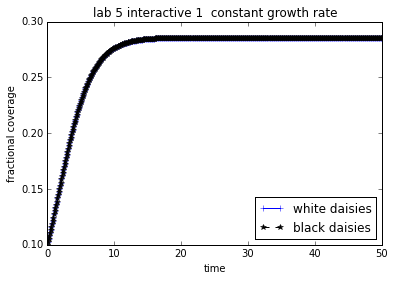

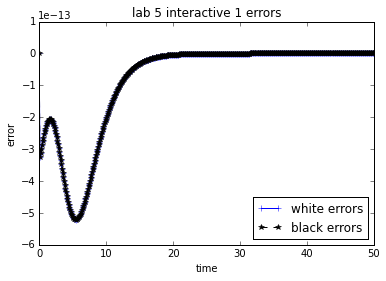

In [6]:
# integrate constant growth rates with fixed timesteps
#
%matplotlib inline
import numlabs.lab5.lab5_funs
from importlib import reload
reload(numlabs.lab5.lab5_funs)
from numlabs.lab5.lab5_funs import Integrator
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt

class Integ51(Integrator):

    def set_yinit(self):
        #
        # read in 'albedo_white chi S0 L albedo_black R albedo_ground'
        #
        uservars = namedtuple('uservars', self.config['uservars'].keys())
        self.uservars = uservars(**self.config['uservars'])
        #
        # read in 'whiteconc blackconc'
        #
        initvars = namedtuple('initvars', self.config['initvars'].keys())
        self.initvars = initvars(**self.config['initvars'])
        self.yinit = np.array(
            [self.initvars.whiteconc, self.initvars.blackconc])
        print("whiteconc")
        print(self.initvars.whiteconc)
        print("blackconc")
        print(self.initvars.blackconc)
        self.nvars = len(self.yinit)
        return None
    #
    # Construct an Integ51 class by inheriting first intializing
    # the parent Integrator class (called super).  Then do the extra
    # initialization in the set_yint function
    #
    def __init__(self, coeffFileName):
        super().__init__(coeffFileName)
        self.set_yinit()

    def derivs5(self, y, t):
        """y[0]=fraction white daisies
           y[1]=fraction black daisies
           
           Constant growty rates for white
           and black daisies beta_w and beta_b
           
           returns dy/dt
        """
        user = self.uservars
        #
        # bare ground
        #
        x = 1.0 - y[0] - y[1]

        # growth rates don't depend on temperature
        beta_b = 0.7  # growth rate for black daisies
        beta_w = 0.7  # growth rate for white daisies

        # create a 1 x 2 element vector to hold the derivitive
        f = np.empty([self.nvars], 'float')
        f[0] = y[0] * (beta_w * x - user.chi)
        f[1] = y[1] * (beta_b * x - user.chi)
 
        return f
    
    

theSolver = Integ51('fixed_growth.yaml')
timeVals, yVals, errorList = theSolver.timeloop5fixed()

plt.close('all')
thefig, theAx = plt.subplots(1,1)
theLines = theAx.plot(timeVals, yVals)
theLines[0].set_marker('+')
theLines[1].set_linestyle('--')
theLines[1].set_color('k')
theLines[1].set_marker('*')
theAx.set_title('lab 5 interactive 1  constant growth rate')
theAx.set_xlabel('time')
theAx.set_ylabel('fractional coverage')
theAx.legend(theLines, ('white daisies', 'black daisies'), loc='best')

thefig, theAx = plt.subplots(1,1)
theLines = theAx.plot(timeVals, errorList)
theLines[0].set_marker('+')
theLines[1].set_linestyle('--')
theLines[1].set_color('k')
theLines[1].set_marker('*')
theAx.set_title('lab 5 interactive 1 errors')
theAx.set_xlabel('time')
theAx.set_ylabel('error')
out=theAx.legend(theLines, ('white errors', 'black errors'), loc='best')